# Perspectives on Utilization of Measurements in Quantum Algorithms

## Valter Uotila, Ilmo Salmenperä, Leo Becker, Arianne Meijer-van de Griend, Aakash Ravindra Shinde and Jukka K. Nurminen

<center>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/8/84/University_of_Helsinki.svg/1280px-University_of_Helsinki.svg.png" alt="HY-logo" width="500" height="500">
</center>

## Outline of this presentation

1. Introduction and motivation
2. Categories for measurement operations
   1. Measure the whole state (Code demo: Recovering the density matrix)
   2. Modify the state by measurements (Code demo: Toffoli gate teleportation)
   3. Measurements as solutions to quantum computational challenges
3. Conclusion

## Introduction

| **Measurement theory**     | **Properties**                                                                                                                                         | **Quantum states** | **Properties**                                                                                      |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------|
| **PVM measurements**      | Idempotent: $P_i^2 = P_i$  <br> Orthogonality: $P_i P_j = \delta_{ij}P_i$ <br> Completeness: $\sum_i P_i = I$                                            | **Pure states**    | Idempotent: $\rho^2 = \rho$ <br> Projection onto 1D subspace <br> Normalization: $\text{Tr}(\rho) = 1$ |
| **POVM measurements**     | Positive operators $E_i \geq 0$ <br> Completeness: $\sum_i E_i = I$ <br> Not necessarily orthogonal <br> Generalization of PVMs                          | **Mixed states**   | Positive operators $\rho \geq 0$ <br> Normalization: $\text{Tr}(\rho) = 1$ <br> Not necessarily pure <br> Generalization of pure states |

## Category 1: Measure the whole state
### Demonstration on Informationally Complete Positive-Valued Operator Measures (IC-POVM)

Consider the following set of POVMs
\begin{align}
    E_{+z} &= p_z |0\rangle\langle0|, &\quad E_{-z} &= p_z |1\rangle\langle1|, \\
    E_{\pm x} &= p_x | \pm \rangle \langle \pm |, &\quad E_{\pm y} &= p_y | \pm i \rangle \langle \pm i |,
\end{align}
where $p_{z}, p_{x}, p_{y} \in [0, 1]$ so that $p_{z} + p_{x} + p_{y} = 1$.

The reconstruction of the state is done with so-called dual operators, which are given by
\begin{align}
    D_{\pm \alpha} = \frac{I \pm \sigma_{\alpha}/p_{\alpha}}{2},
\end{align}
where $\sigma_{\alpha}$ is the corresponding Pauli matrix, $p_{\alpha}$ is the probability and $\alpha \in \left\{x, y, z \right\}$.

With the dual operators, the reconstructed state $\rho$ has the following form
\begin{align}
    \rho = \sum_{k \in I} \mathrm{Tr}(\rho E_k) D_k.
\end{align}

In [1]:
from povm_toolbox.sampler import POVMSampler 
from povm_toolbox.library import ClassicalShadows
from povm_toolbox.post_processor import POVMPostProcessor

from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [20]:
backend = Aer.get_backend('statevector_simulator') 
#backend = FakeManilaV2()
#n_qubits = backend.configuration().n_qubits
#gate_set = backend.configuration().supported_instructions
#print("Number of qubits is ", n_qubits)
#print("Native gate set is ", gate_set)

Number of qubits is  30


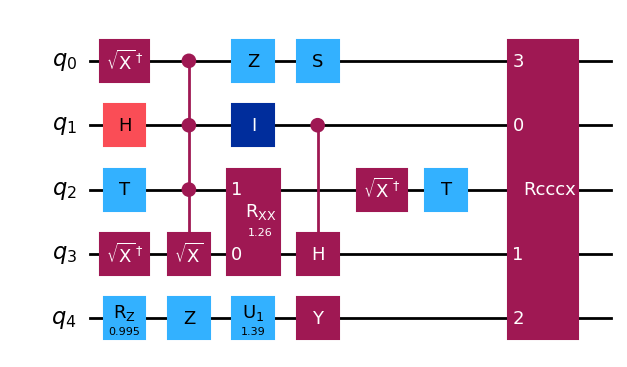

In [21]:
from qiskit.circuit.random import random_circuit

n_qubits = 5
circuit = random_circuit(n_qubits, 5, measure=False)
circuit.draw(output='mpl')

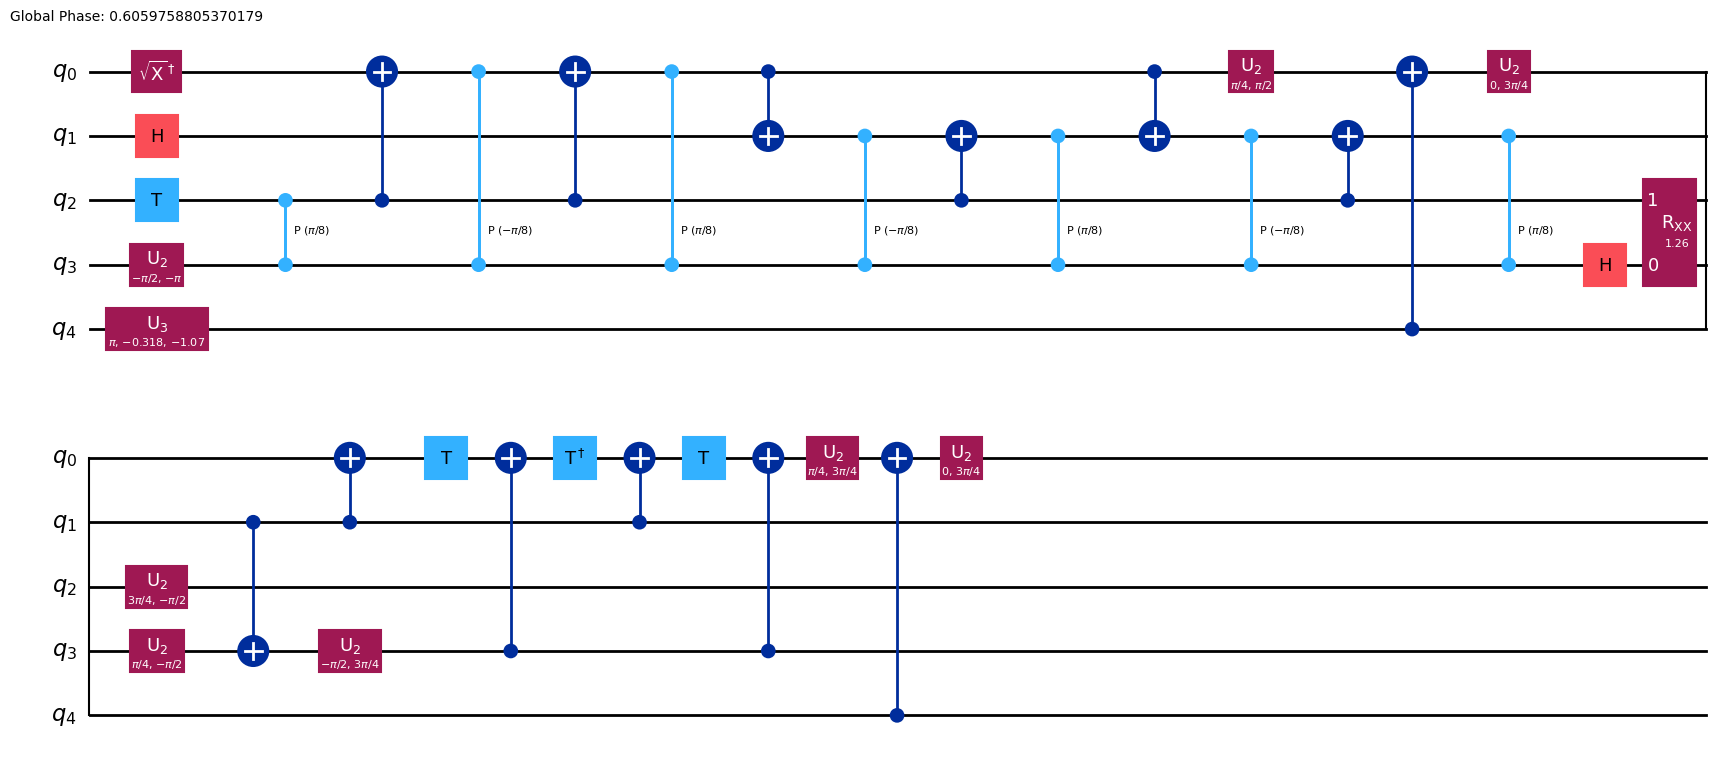

In [22]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_circuit = pm.run(circuit)
transpiled_circuit.draw(output='mpl')

In [26]:
sampler = Sampler(mode=backend)
povm_sampler = POVMSampler(sampler=sampler)
measurement = ClassicalShadows(num_qubits=n_qubits, seed=0)

shots = 2000

job = povm_sampler.run([circuit], shots=shots, povm=measurement, pass_manager=pm)
result = job.result()
pub_result = result[0]
counts = pub_result.get_counts()

observable = SparsePauliOp.from_list([("ZIIII", 1), ("IZIII", 1), ("IIZII", 1), ("IIIZI", 1), ("IIIIZ", 1)])

post_processor = POVMPostProcessor(pub_result)
exp_value, std= post_processor.get_expectation_value(observable)
print("Noisy expectation value: ", exp_value)

Noisy expectation value:  -0.9464999999999999


In [27]:
statevector = Statevector.from_instruction(circuit)

# Compute the exact expectation value
expectation_value = statevector.expectation_value(observable)
print("Expectation value:", expectation_value.real)

Expectation value: -0.9999999999999992


In [28]:
probabilities = {}
for res, count in counts.items():
   c = (int(r) for r in res)
   probabilities[tuple(c)] = count / shots

In [30]:
from qiskit.quantum_info import Operator, DensityMatrix
from functools import reduce
import operator

density_matrix = None

for state, prob in probabilities.items():
    duals = [post_processor.dual[(qubit_id,)].operators[povm_id] for qubit_id, povm_id in enumerate(reversed(state))]
    
    # Convert to Operators
    dual_operators = [Operator(dual) for dual in duals]
    
    # Compute tensor product using reduce
    tensor_product_op = reduce(lambda a, b: a.tensor(b), dual_operators)
    
    # Scale and accumulate
    if density_matrix is None:
        density_matrix = prob * tensor_product_op
    else:
        density_matrix = density_matrix + prob * tensor_product_op

density_matrix = DensityMatrix(density_matrix.data)

# Compute expectation value
expectation_value = density_matrix.expectation_value(observable)
print(f"Expectation value: {expectation_value.real}")

Expectation value: -0.946499999999992


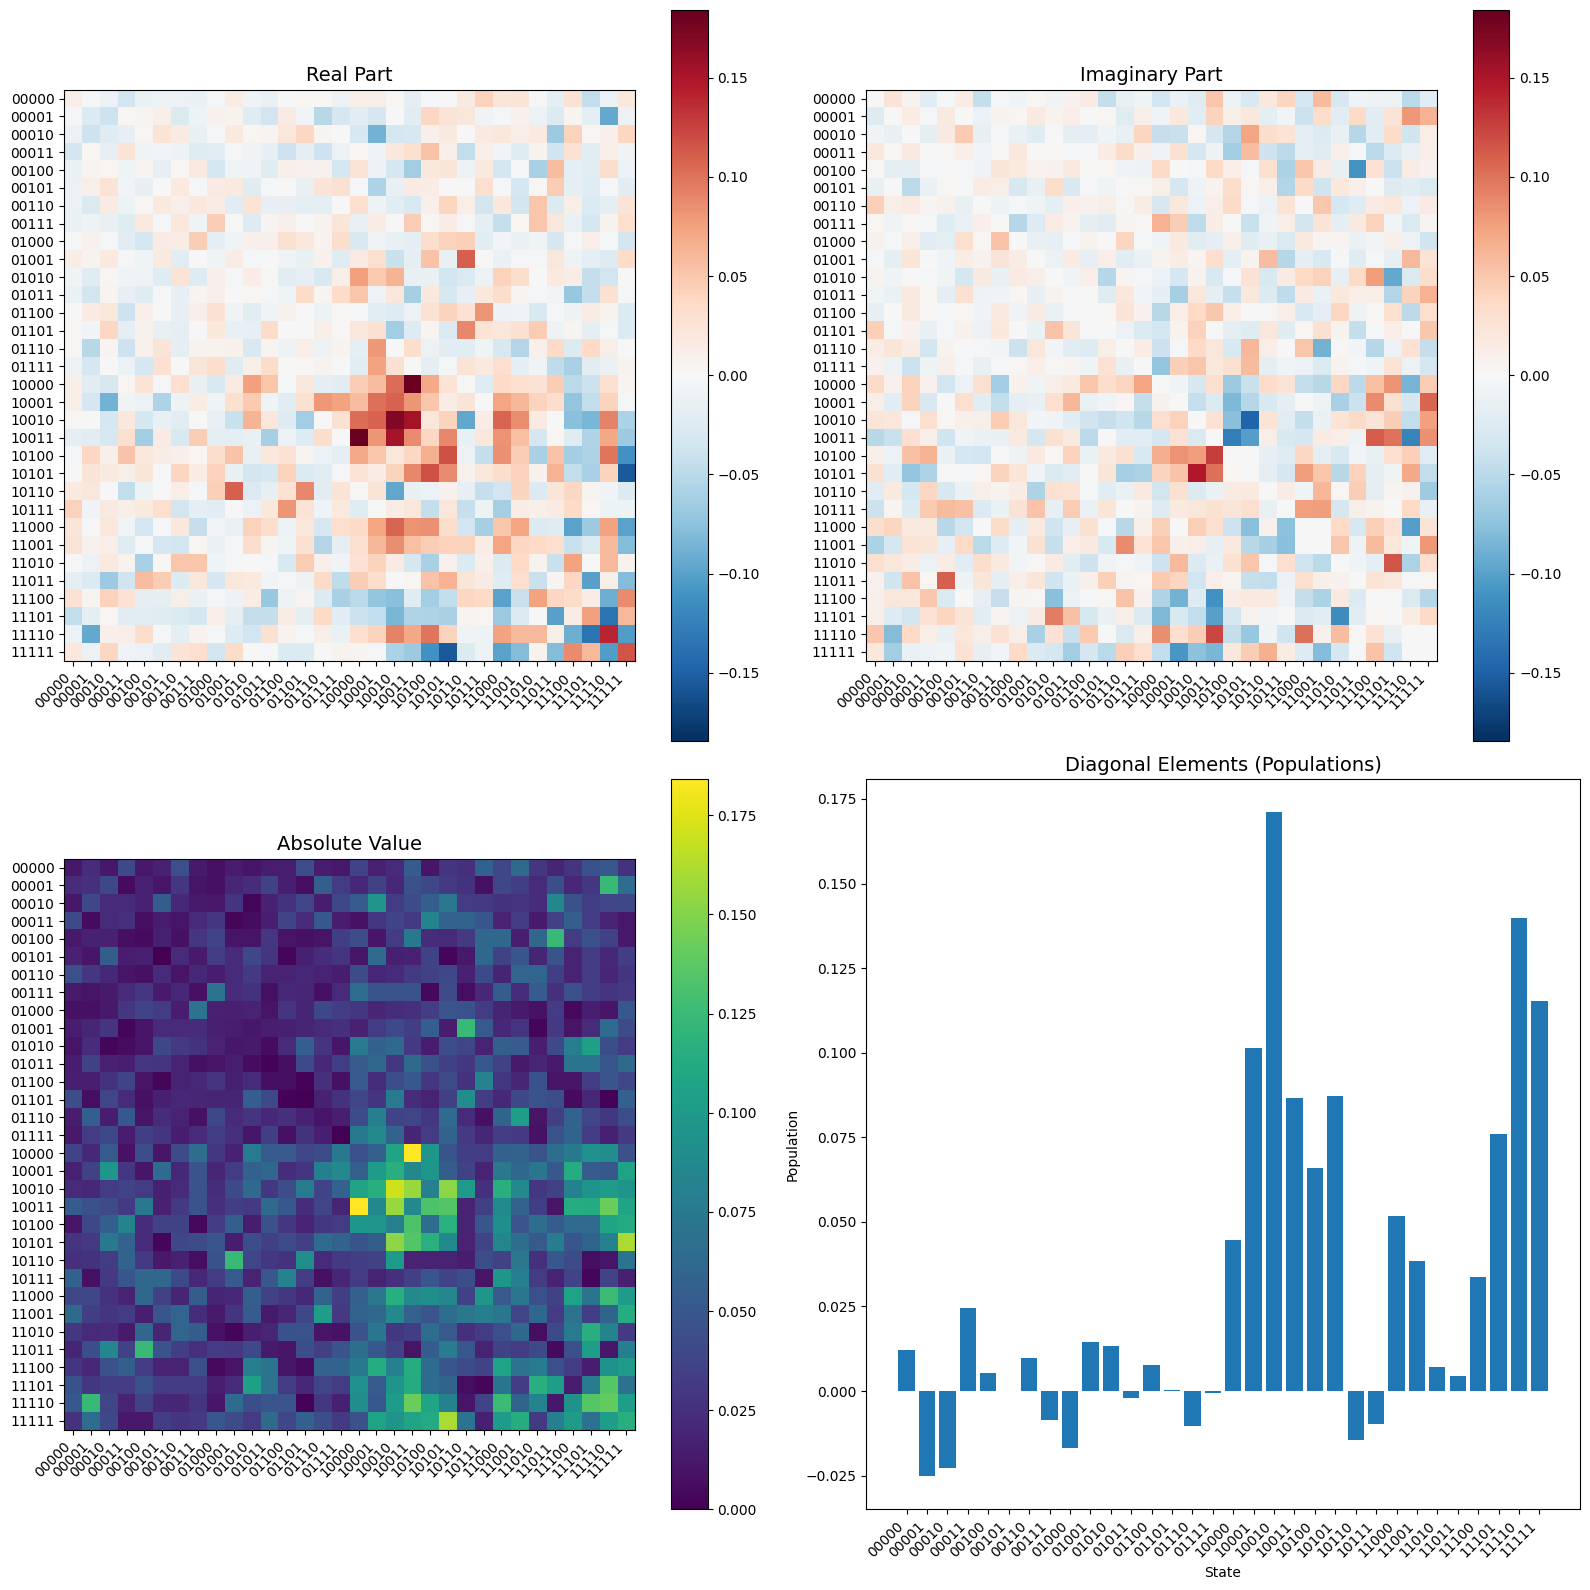

Trace: 1.000000+0.000000j
Purity: 2.751175
Max diagonal element: 0.171125
Min diagonal element: -0.025187


In [35]:
import numpy as np
def plot_density_matrix_enhanced(density_matrix, n_qubits):
    """Enhanced density matrix visualization with state labels."""
    rho = density_matrix.data if hasattr(density_matrix, 'data') else density_matrix
    
    # Generate state labels
    states = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
    
    # Real part
    im1 = ax1.imshow(np.real(rho), cmap='RdBu_r', vmin=-np.max(np.abs(rho)), vmax=np.max(np.abs(rho)))
    ax1.set_title('Real Part', fontsize=14)
    ax1.set_xticks(range(len(states)))
    ax1.set_yticks(range(len(states)))
    ax1.set_xticklabels(states, rotation=45, ha='right')
    ax1.set_yticklabels(states)
    plt.colorbar(im1, ax=ax1)
    
    # Imaginary part
    im2 = ax2.imshow(np.imag(rho), cmap='RdBu_r', vmin=-np.max(np.abs(rho)), vmax=np.max(np.abs(rho)))
    ax2.set_title('Imaginary Part', fontsize=14)
    ax2.set_xticks(range(len(states)))
    ax2.set_yticks(range(len(states)))
    ax2.set_xticklabels(states, rotation=45, ha='right')
    ax2.set_yticklabels(states)
    plt.colorbar(im2, ax=ax2)
    
    # Absolute value
    im3 = ax3.imshow(np.abs(rho), cmap='viridis', vmin=0, vmax=np.max(np.abs(rho)))
    ax3.set_title('Absolute Value', fontsize=14)
    ax3.set_xticks(range(len(states)))
    ax3.set_yticks(range(len(states)))
    ax3.set_xticklabels(states, rotation=45, ha='right')
    ax3.set_yticklabels(states)
    plt.colorbar(im3, ax=ax3)
    
    # Diagonal elements (populations)
    diagonal = np.diag(rho).real
    ax4.bar(range(len(diagonal)), diagonal)
    ax4.set_title('Diagonal Elements (Populations)', fontsize=14)
    ax4.set_xlabel('State')
    ax4.set_ylabel('Population')
    ax4.set_xticks(range(len(states)))
    ax4.set_xticklabels(states, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
# Use the enhanced visualization
plot_density_matrix_enhanced(density_matrix, n_qubits)

In [38]:
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_state_qsphere
import matplotlib.pyplot as plt

# Assuming you have your density matrix
#density_matrix = DensityMatrix(noisy_density_matrix_tensor.data.reshape(2**n_qubits, 2**n_qubits))

# City plot (3D bars showing real and imaginary parts)
fig1 = plot_state_city(density_matrix, title="Density Matrix - City Plot")
plt.show()

# Hinton diagram (squares with size proportional to magnitude)
fig2 = plot_state_hinton(density_matrix, title="Density Matrix - Hinton Plot")
plt.show()

## Toffoli gate teleportation

In [ ]:
import pennylane as qml
import numpy as np

# Using the notation in the paper
# input0 -> 0
# input1 -> 1
# input2 -> 2
# ancilla0 -> 3
# ancilla1 -> 4
# ancilla2 -> 5
# output0 -> 6
# output1 -> 7
# output2 -> 8

# Get matrix for toffoli gate
def get_toffoli_matrix():
    return np.array(qml.Toffoli(wires=[0,1,2]).matrix())

X0 = qml.PauliX(0)
Z0 = qml.PauliZ(0)
X1 = qml.PauliX(1)
Z1 = qml.PauliZ(1)
X2 = qml.PauliX(2)
Z2 = qml.PauliZ(2)
I0 = qml.Identity(0)
I1 = qml.Identity(1)
I2 = qml.Identity(2)

basis = [Z0 @ I1 @ I2, 
        I0 @ Z1 @ I2,
        I0 @ I1 @ Z2,
        X0 @ I1 @ I2,
        I0 @ X1 @ I2,
        I0 @ I1 @ X2]

results = []
for b in basis:
    results.append(get_toffoli_matrix() @ b.matrix() @ get_toffoli_matrix())
    
pauli_decomposed = []

for result in results:
    pauli_decomposed.append(qml.pauli_decompose(result, wire_order=[6, 7, 8]))
    
hamiltonians = []

for p in pauli_decomposed:
    print(p.coeffs, p.ops)

# Braket and qiskit aer are able to visualize the decompositions
#dev = qml.device("braket.local.qubit", wires=[6, 7, 8], shots=1)
#dev = qml.device("qiskit.aer", wires=[6, 7, 8], shots=1)
dev = qml.device("default.qubit", wires=[6, 7, 8], shots=1)

@qml.qnode(dev)
def circuit(p):
    hamiltonian = qml.Hamiltonian(p.coeffs, p.ops)
    if len(p.coeffs) == 1:
        qml.exp(hamiltonian, num_steps=1, coeff=1j)
    else:
        qml.exp(hamiltonian, num_steps=1, coeff=1j)
    return qml.sample()

for i, p in enumerate(pauli_decomposed):
    qml.draw_mpl(circuit, expansion_strategy="device", show_all_wires=True, decimals=1)(p)